<a href="https://colab.research.google.com/github/Requenamar3/Data-Mining/blob/main/Copy_of_Face_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle -qqq

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!cp '/content/kaggle.json' ~/.kaggle/kaggle.json

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kaggle

kaggle.api.dataset_download_files('msambare/fer2013', path='./data', unzip=True)

## **Importing Libraries**
**Importing the required python libraries like numpy, seaborn, matplotlib, tensorflow.**

In [ ]:
# Importing all the required Libraries for Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import os

# Removing all those annoying Warnings

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [ ]:
data="/content/data"

In [ ]:
# CONFIRM THAT THIS REPORTS BACK 'test', and 'train'
os.listdir(data)

['train', 'test']

In [ ]:
#setting up test and train path
test_path = data +'/test/'
train_path = data +'/train/'

In [ ]:
#list the directory of test path
os.listdir(test_path)

['neutral', 'fear', 'angry', 'surprise', 'disgust', 'happy', 'sad']

In [ ]:
#list the directory of trian path
os.listdir(train_path)

['neutral', 'fear', 'angry', 'surprise', 'disgust', 'happy', 'sad']

In [ ]:
#getting the first image of angry folder
os.listdir(train_path+'/angry')[0]

'Training_57743136.jpg'

In [ ]:
img = train_path+'/angry'+'/Training_10118481.jpg'

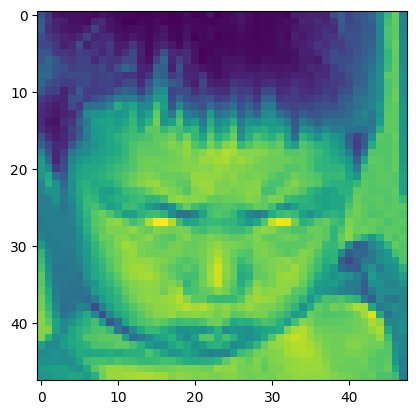

In [ ]:
#showing the first image of angry folder
plt.imshow(imread(img))

In [ ]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

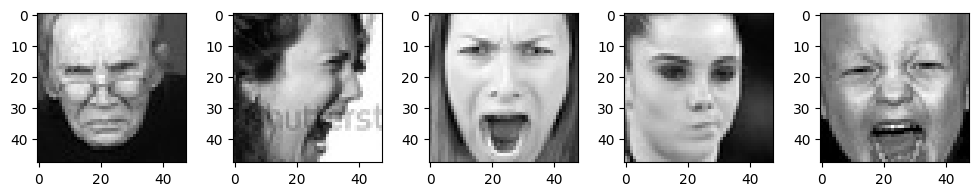

In [ ]:
#sample of angry class
plot_images(train_path+'/angry')

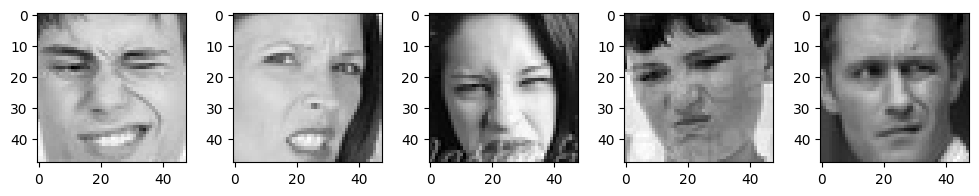

In [ ]:
#sample of disgust class
plot_images(train_path+'/disgust')

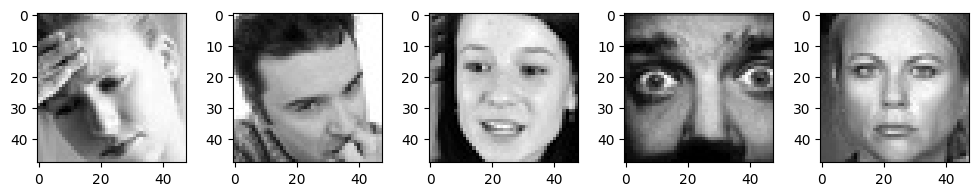

In [ ]:
#sample of fear class
plot_images(train_path+'/fear')

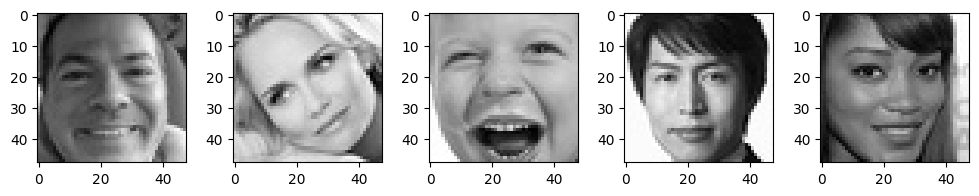

In [ ]:
#sample of happy class
plot_images(train_path+'/happy')

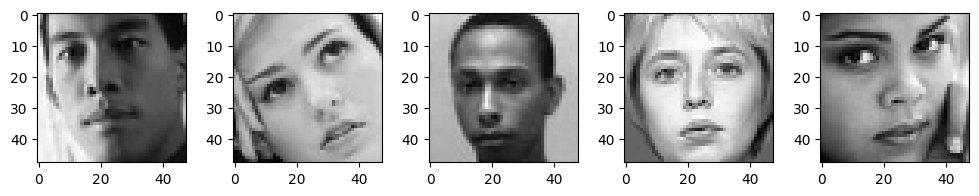

In [ ]:
#sample of neutral class
plot_images(train_path+'/neutral')

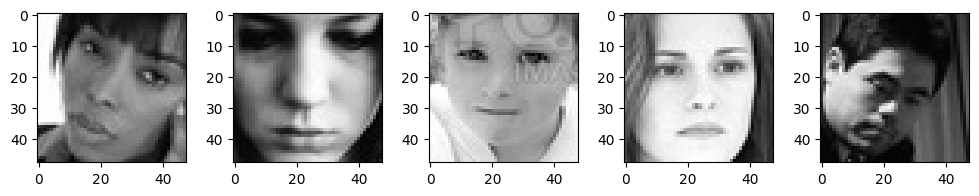

In [ ]:
#sample of sad class
plot_images(train_path+'/sad')

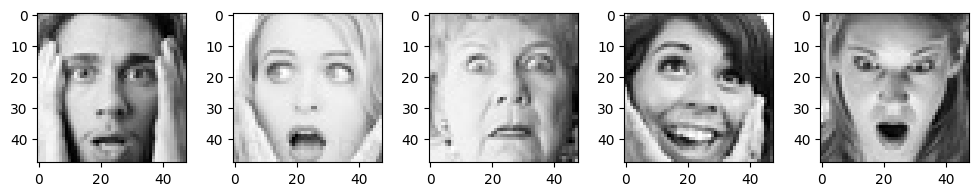

In [ ]:
#sample of surprise class
plot_images(train_path+'/surprise')

In [ ]:
for expression in os.listdir(train_path):
    print(str(len(os.listdir(train_path + expression))) + " " + expression + " images")

4965 neutral images
4097 fear images
3995 angry images
3171 surprise images
436 disgust images
7215 happy images
4830 sad images


## **Setup the data generators for CNN model**

**Now we will generate training and testing (validation) batches.**

In [ ]:
# Creating Image generators, for all train, validation, and test set
training_gen=ImageDataGenerator(rescale=1./255)
testing_gen=ImageDataGenerator(rescale=1./255)

In [ ]:
# Creating  Training Dataset

train_gen=training_gen.flow_from_directory(train_path,
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical')

# Creating Test Set

test_gen=testing_gen.flow_from_directory(test_path,
                                           target_size=(48,48),
                                           batch_size=32,
                                           color_mode='grayscale',
                                           class_mode='categorical',
                                           shuffle= False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## **Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.**
**As of now we have imported libraries, got dataset, and created train and test images.**

In [ ]:
#printing the class indicies og train_gen
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


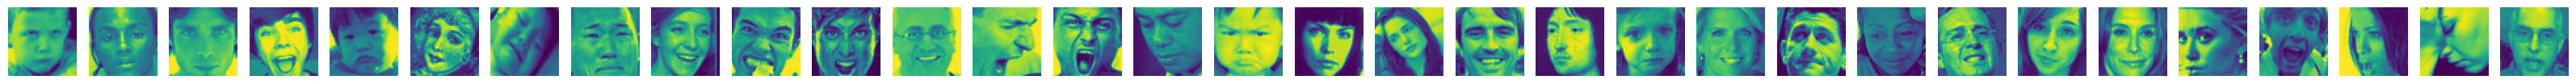

sad   neutral   neutral   happy   sad   happy   angry   sad   happy   fear   fear   happy   angry   angry   sad   angry   sad   sad   happy   neutral   fear   happy   angry   sad   angry   sad   happy   neutral   happy   surprise   sad   neutral   

In [ ]:
imgs,lables=next(train_gen)                                                                   # Extracting next batch to plot it, this batch of photos are selected randomly
list_of_keys=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']                  # list of Classes
def plotImages(images_arr):
  fig, axes= plt.subplots(1,32,figsize=(32,2))
  axes= axes.flatten()
  for img, ax in zip(images_arr,axes):
    ax.imshow(img)
    ax.axis('off')
  plt.tight_layout()
  plt.show()
plotImages(imgs)
for i in lables[:32]:                                                                             # Printing the lables below the respective image
  for num, j in enumerate(i):
    if j==1:
      print(list_of_keys[num], end='   ')                                                         # Labelling seems to be spot on
num+=1

## **Building the CNN Model**
**We chose to use a Convolutional Neural Network in order to tackle this face recognition problem. Indeed this type of Neural Network (NN) is good for extracting the features of images and is widely used for image analysis subjects like image classification.**

In [ ]:
# from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model = Sequential()

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))


# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

#output layer
model.add(Dense(no_of_classes, activation='softmax'))
opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

## **We define our CNN with the following global architecture:**

* 4 convolutional layers
* 2 fully connected layers

## **Basic CNN architecture details:**

* Input layer - Input layer in CNN should contain image data
* Convo layer - Convo layer is sometimes called feature extractor layer because features of the image are get extracted within this layer
* Pooling layer - Pooling is used to reduce the dimensionality of each features while retaining the most important information. It is used between two convolution layer
* Fully CL - Fully connected layer involves weights, biases, and neurons. It connects neurons in one layer to neurons in another layer. It is used to classify images between different category by training and placed before the output layer
* Output Layer - Output layer contains the label which is in the form of one-hot encoded

**Also we use some common techniques for each layer**

* Batch normalization: improves the performance and stability of NNs by providing inputs with zero mean and unit variance.
* Dropout: reduces overfitting by randomly not updating the weights of some nodes. This helps prevent the NN from relying on one node in the layer too much.

## **Train the model**
**Now it’s time to train the model and evaluate the results.**

In [ ]:
# Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

checkpoint = ModelCheckpoint('./my_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')          # Adding various Call Backs Like Early stopping to prevent overfitting and Decay Learning Rate to prevent Overshooting

#early stopping
early_stopping=EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            verbose=1,
                            restore_best_weights=True)
decay_lr= ReduceLROnPlateau(monitor='val_loss',
                           factor=0.2,
                           patience=3,
                           verbose=1,
                           min_delta=0.0001)
callbacks=[early_stopping,checkpoint,decay_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
#fitting the generator

history = model.fit_generator(generator=train_gen,
                                steps_per_epoch=train_gen.n//train_gen.batch_size,
                                epochs=40,
                                validation_data = test_gen,
                                validation_steps = test_gen.n//test_gen.batch_size,
                                callbacks=callbacks
                                )

Epoch 1/40
895/897 [============================>.] - ETA: 0s - loss: 1.7290 - accuracy: 0.3295

897/897 [==============================] - 38s 30ms/step - loss: 1.7282 - accuracy: 0.3297 - val_loss: 1.5403 - val_accuracy: 0.4103 - lr: 0.0010
Epoch 2/40
896/897 [============================>.] - ETA: 0s - loss: 1.3631 - accuracy: 0.4766

897/897 [==============================] - 30s 34ms/step - loss: 1.3628 - accuracy: 0.4767 - val_loss: 1.3842 - val_accuracy: 0.4831 - lr: 0.0010
Epoch 3/40
897/897 [==============================] - ETA: 0s - loss: 1.2409 - accuracy: 0.5282

897/897 [==============================] - 27s 30ms/step - loss: 1.2409 - accuracy: 0.5282 - val_loss: 1.3553 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 4/40
895/897 [============================>.] - ETA: 0s - loss: 1.1719 - accuracy: 0.5550

897/897 [==============================] - 26s 29ms/step - loss: 1.1718 - accuracy: 0.5551 - val_loss: 1.3477 - val_accuracy: 0.4852 - lr: 0.0010
Epoch 5/40
897/897 [==============================] - ETA: 0s - loss: 1.1221 - accuracy: 0.5716

897/897 [==============================] - 26s 29ms/step - loss: 1.1221 - accuracy: 0.5716 - val_loss: 1.1892 - val_accuracy: 0.5282 - lr: 0.0010
Epoch 6/40
897/897 [==============================] - ETA: 0s - loss: 1.0716 - accuracy: 0.5943

897/897 [==============================] - 27s 30ms/step - loss: 1.0716 - accuracy: 0.5943 - val_loss: 1.1351 - val_accuracy: 0.5760 - lr: 0.0010
Epoch 7/40
895/897 [============================>.] - ETA: 0s - loss: 1.0270 - accuracy: 0.6131

897/897 [==============================] - 25s 28ms/step - loss: 1.0267 - accuracy: 0.6132 - val_loss: 1.2343 - val_accuracy: 0.5269 - lr: 0.0010
Epoch 8/40
896/897 [============================>.] - ETA: 0s - loss: 0.9787 - accuracy: 0.6317

897/897 [==============================] - 26s 29ms/step - loss: 0.9786 - accuracy: 0.6317 - val_loss: 1.1348 - val_accuracy: 0.5759 - lr: 0.0010
Epoch 9/40
896/897 [============================>.] - ETA: 0s - loss: 0.9196 - accuracy: 0.6528

897/897 [==============================] - 27s 30ms/step - loss: 0.9194 - accuracy: 0.6530 - val_loss: 1.0422 - val_accuracy: 0.6032 - lr: 0.0010
Epoch 10/40
897/897 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.6741

897/897 [==============================] - 26s 29ms/step - loss: 0.8716 - accuracy: 0.6741 - val_loss: 1.0483 - val_accuracy: 0.6177 - lr: 0.0010
Epoch 11/40
897/897 [==============================] - ETA: 0s - loss: 0.8226 - accuracy: 0.6909

897/897 [==============================] - 28s 31ms/step - loss: 0.8226 - accuracy: 0.6909 - val_loss: 1.1470 - val_accuracy: 0.5677 - lr: 0.0010
Epoch 12/40
896/897 [============================>.] - ETA: 0s - loss: 0.7734 - accuracy: 0.7116


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
897/897 [==============================] - 26s 29ms/step - loss: 0.7736 - accuracy: 0.7115 - val_loss: 1.1335 - val_accuracy: 0.6024 - lr: 0.0010
Epoch 13/40
895/897 [============================>.] - ETA: 0s - loss: 0.6210 - accuracy: 0.7712

897/897 [==============================] - 27s 30ms/step - loss: 0.6211 - accuracy: 0.7711 - val_loss: 1.0200 - val_accuracy: 0.6514 - lr: 2.0000e-04
Epoch 14/40
895/897 [============================>.] - ETA: 0s - loss: 0.5664 - accuracy: 0.7914

897/897 [==============================] - 26s 29ms/step - loss: 0.5664 - accuracy: 0.7914 - val_loss: 1.0386 - val_accuracy: 0.6571 - lr: 2.0000e-04
Epoch 15/40
896/897 [============================>.] - ETA: 0s - loss: 0.5292 - accuracy: 0.8032

897/897 [==============================] - 26s 29ms/step - loss: 0.5292 - accuracy: 0.8032 - val_loss: 1.0566 - val_accuracy: 0.6602 - lr: 2.0000e-04
Epoch 16/40
897/897 [==============================] - ETA: 0s - loss: 0.4960 - accuracy: 0.8161


Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
897/897 [==============================] - 28s 31ms/step - loss: 0.4960 - accuracy: 0.8161 - val_loss: 1.0877 - val_accuracy: 0.6557 - lr: 2.0000e-04
Epoch 17/40
895/897 [============================>.] - ETA: 0s - loss: 0.4604 - accuracy: 0.8319

897/897 [==============================] - 25s 28ms/step - loss: 0.4602 - accuracy: 0.8320 - val_loss: 1.0827 - val_accuracy: 0.6649 - lr: 4.0000e-05
Epoch 18/40
895/897 [============================>.] - ETA: 0s - loss: 0.4479 - accuracy: 0.8351Restoring model weights from the end of the best epoch: 13.


897/897 [==============================] - 25s 28ms/step - loss: 0.4479 - accuracy: 0.8351 - val_loss: 1.0934 - val_accuracy: 0.6655 - lr: 4.0000e-05
Epoch 18: early stopping


* ## **Our best model managed to obtain a accuracy of approximately 82% and val_accuracy of 65% on the dataset by running 50 epochs.which is quite good.**
* ## **At each epoch, Keras checks if our model performed better than the models of the previous epochs.**


In [ ]:
predictions=model.predict(test_gen)                                                                               # Predicting For Test Set
cm=confusion_matrix(y_pred=np.argmax(predictions, axis=-1), y_true=test_gen.classes)                                  # Printing Confution Matrix
cm

225/225 [==============================] - 4s 15ms/step


array([[ 593,   12,   84,   45,   92,  106,   26],
       [  30,   66,    1,    5,    3,    4,    2],
       [ 123,    8,  454,   37,  110,  161,  131],
       [  51,    2,   34, 1496,  101,   49,   41],
       [ 111,    3,   76,   90,  746,  171,   36],
       [ 168,    3,  149,   73,  211,  624,   19],
       [  21,    3,   41,   36,   18,   13,  699]])

In [ ]:
aoc=accuracy_score(y_pred=np.argmax(predictions, axis=-1),y_true=test_gen.classes)                                    # Accuracy Score of Our Model
aoc

0.6517135692393424

## **Saving Model**

In [ ]:
model.save('Malik_CNN_model.h5')

In [ ]:
%pwd

'/content'

## **Plotting Accuracy & Loss to analyze the results**

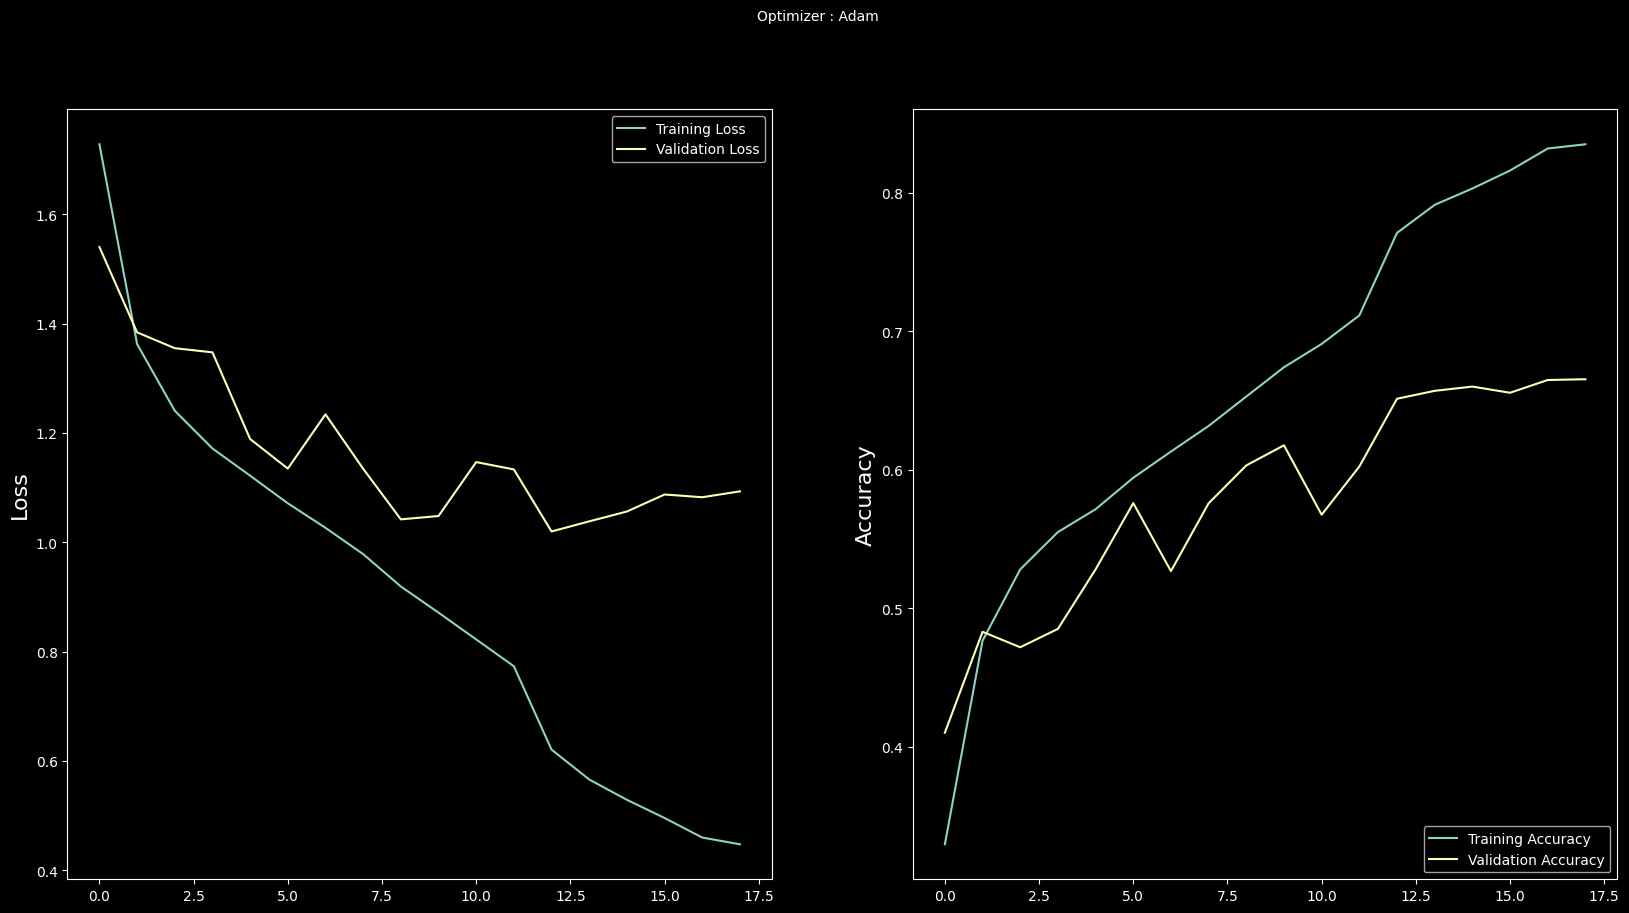

In [ ]:
#Plotting Accuracy & Loss
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

## **The training loss is slightly higher than the validation loss for the first epochs.**

## **Confusion matrix**
**Finally we can plot the confusion matrix in order to see how our model classified the images:**

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

<Figure size 640x480 with 0 Axes>

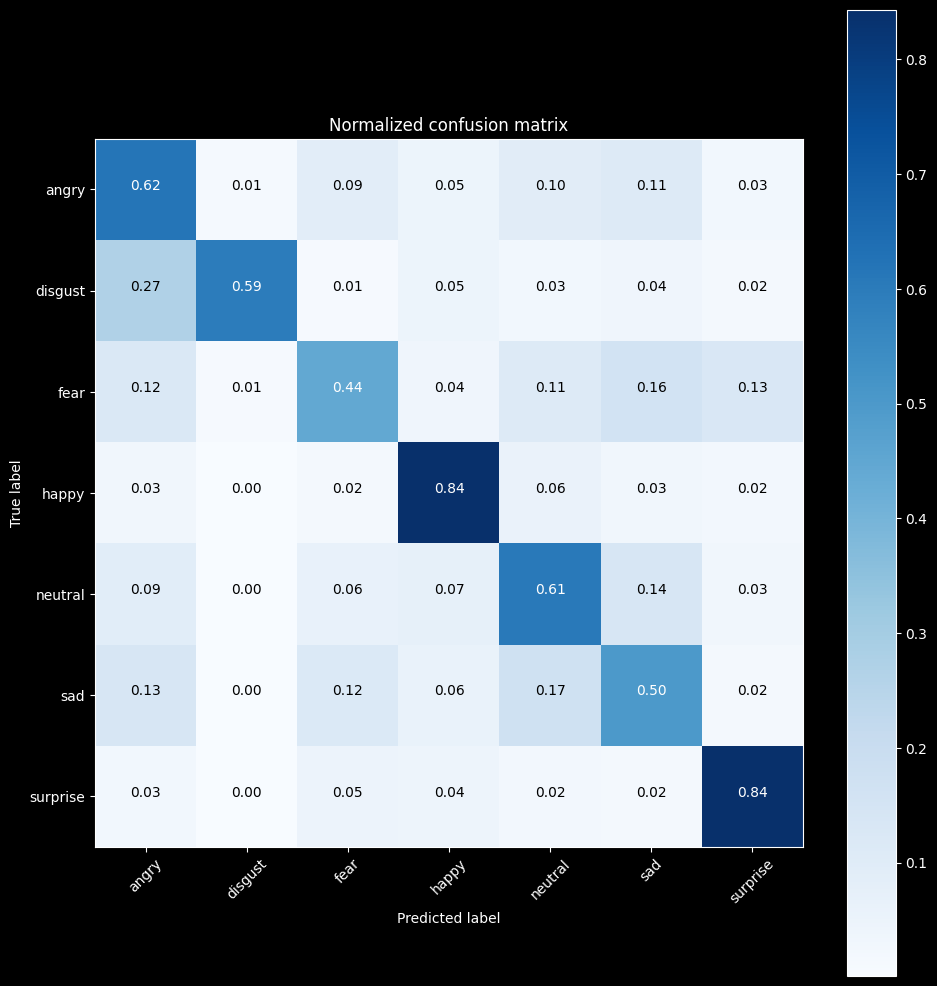

In [ ]:
# show the confusion matrix of our predictions

# compute predictions
predictions = model.predict_generator(generator=test_gen)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = test_gen.classes
class_names = test_gen.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')# **Live Class Monitoring System(Face Emotion Recognition)**
    plt.xlabel('Predicted label')
    plt.tight_layout()

# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

## **Our model is very good for predicting happy and surprised faces. However it predicts quite poorly feared faces maybe because it confuses them with sad faces.**

## **Real Time Face Prediction**

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

face_classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
classifier = load_model("Malik_CNN_model.h5")

emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    labels = []

    if not ret:
        print("Unable to grab frame from camera. Check camera input.")
        break

    if frame is not None:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_classifier.detectMultiScale(gray)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 255), 2)
            roi_gray = gray[y:y+h, x:x+w]
            roi_gray = cv2.resize(roi_gray, (48, 48), interpolation=cv2.INTER_AREA)

            if np.sum([roi_gray]) != 0:
                roi = roi_gray.astype('float')/255.0
                roi = img_to_array(roi)
                roi = np.expand_dims(roi, axis=0)

                prediction = classifier.predict(roi)[0]
                label = emotion_labels[prediction.argmax()]
                label_position = (x, y)
                cv2.putText(frame, label, label_position, cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            else:
                cv2.putText(frame, 'No Face Found', (30, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow('Emotion Detector', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        print("Frame is empty.")

cap.release()
cv2.destroyAllWindows()


Unable to grab frame from camera. Check camera input.


## **Conclusion**
* **Our model is giving an accuracy of 82% and is robust in that it works well even in a dim light environment.**
* **The application is able to detect face location and predict the right expression while checking it on a local webcam.**
* **The front-end of the model was made using streamlit for webapp and running well on local webapp link.**
* **Finally, we successfully deployed the Streamlit WebApp on Heroku and Streamlit share that runs on a web server.**
* **And I believe that through this model teachers can understand the students' perception during online classes and change the way of teaching if needed by understanding the students’ motive.**